# Drug–drug interaction prediction


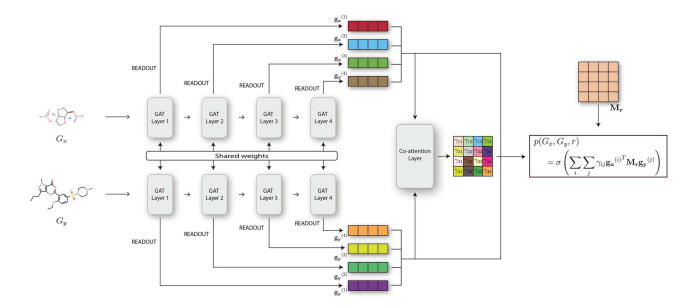

# ⚙️ 1. Setup Environment

In [1]:
!pip install torch_geometric
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.7 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 40.9 MB/s eta 0:00:0000:0100:01


# 🧾 2. Loading Data and Preprocessing

**DrugBank** is a comprehensive and widely used dataset in the field of pharmacology and drug research. It serves as a valuable resource for researchers, clinicians, and pharmaceutical companies by providing detailed information on drugs, their targets, interactions, and various other properties. The dataset encompasses a vast amount of knowledge and is continuously updated to reflect the latest advancements in the field.

The DrugBank dataset contains information on thousands of drugs, including both approved and experimental compounds. It includes data on drug names, chemical structures, indications, contraindications, side effects, pharmacokinetics, drug interactions, and mechanisms of action. This information is essential for understanding the therapeutic properties and potential risks associated with specific drugs.
- One of the key features of DrugBank is its rich collection of drug-target interactions. It provides data on the molecular targets of drugs, such as receptors, enzymes, transporters, and ion channels. This information helps researchers gain insights into the biological mechanisms underlying drug action and allows for the identification of new targets for drug development.
- In addition to drug-target interactions, DrugBank also captures data on drug-drug interactions. This aspect is crucial for assessing potential drug combinations and identifying any possible adverse effects or interactions that may occur when multiple drugs are used concurrently.
- The dataset further includes information on drug metabolism, absorption, distribution, excretion, and toxicity (ADMET). These properties are vital in evaluating the safety and efficacy of drugs and are essential considerations during the drug development process.

In [2]:
import itertools
from collections import defaultdict
from operator import neg
import random
import math

import torch
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
from rdkit import Chem
import pandas as pd
import numpy as np

df_drugs_smiles = pd.read_csv('/kaggle/input/gnn-ddi/data/drug_smiles.csv')

DRUG_TO_INDX_DICT = {drug_id: indx for indx, drug_id in enumerate(df_drugs_smiles['drug_id'])}

drug_id_mol_graph_tup = [(id, Chem.MolFromSmiles(smiles.strip())) for id, smiles in zip(df_drugs_smiles['drug_id'], df_drugs_smiles['smiles'])]


# Gettings information and features of atoms
ATOM_MAX_NUM = np.max([m[1].GetNumAtoms() for m in drug_id_mol_graph_tup])
AVAILABLE_ATOM_SYMBOLS = list({a.GetSymbol() for a in itertools.chain.from_iterable(m[1].GetAtoms() for m in drug_id_mol_graph_tup)})
AVAILABLE_ATOM_DEGREES = list({a.GetDegree() for a in itertools.chain.from_iterable(m[1].GetAtoms() for m in drug_id_mol_graph_tup)})
AVAILABLE_ATOM_TOTAL_HS = list({a.GetTotalNumHs() for a in itertools.chain.from_iterable(m[1].GetAtoms() for m in drug_id_mol_graph_tup)})
max_valence = max(a.GetImplicitValence() for a in itertools.chain.from_iterable(m[1].GetAtoms() for m in drug_id_mol_graph_tup))
max_valence = max(max_valence, 9)
AVAILABLE_ATOM_VALENCE = np.arange(max_valence + 1)

MAX_ATOM_FC = abs(np.max([a.GetFormalCharge() for a in itertools.chain.from_iterable(m[1].GetAtoms() for m in drug_id_mol_graph_tup)]))
MAX_ATOM_FC = MAX_ATOM_FC if MAX_ATOM_FC else 0
MAX_RADICAL_ELC = abs(np.max([a.GetNumRadicalElectrons() for a in itertools.chain.from_iterable(m[1].GetAtoms() for m in drug_id_mol_graph_tup)]))
MAX_RADICAL_ELC = MAX_RADICAL_ELC if MAX_RADICAL_ELC else 0


def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

def atom_features(atom,
                explicit_H=True,
                use_chirality=False):

    results = one_of_k_encoding_unk(
        atom.GetSymbol(),
        ['C','N','O', 'S','F','Si','P', 'Cl','Br','Mg','Na','Ca','Fe','As','Al','I','B','V','K','Tl',
            'Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn','H', 'Li','Ge','Cu','Au','Ni','Cd','In',
            'Mn','Zr','Cr','Pt','Hg','Pb','Unknown'
        ]) + [atom.GetDegree()/10, atom.GetImplicitValence(),
                atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + \
                one_of_k_encoding_unk(atom.GetHybridization(), [
                Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.
                                    SP3D, Chem.rdchem.HybridizationType.SP3D2
                ]) + [atom.GetIsAromatic()]
    # In case of explicit hydrogen(QM8, QM9), avoid calling `GetTotalNumHs`
    if explicit_H:
        results = results + [atom.GetTotalNumHs()]

    if use_chirality:
        try:
            results = results + one_of_k_encoding_unk(
            atom.GetProp('_CIPCode'),
            ['R', 'S']) + [atom.HasProp('_ChiralityPossible')]
        except:
            results = results + [False, False
                            ] + [atom.HasProp('_ChiralityPossible')]

    results = np.array(results).astype(np.float32)

    return torch.from_numpy(results)


def get_atom_features(atom, mode='one_hot'):

    if mode == 'one_hot':
        atom_feature = torch.cat([
            one_of_k_encoding_unk(atom.GetSymbol(), AVAILABLE_ATOM_SYMBOLS),
            one_of_k_encoding_unk(atom.GetDegree(), AVAILABLE_ATOM_DEGREES),
            one_of_k_encoding_unk(atom.GetTotalNumHs(), AVAILABLE_ATOM_TOTAL_HS),
            one_of_k_encoding_unk(atom.GetImplicitValence(), AVAILABLE_ATOM_VALENCE),
            torch.tensor([atom.GetIsAromatic()], dtype=torch.float)
        ])
    else:
        atom_feature = torch.cat([
            one_of_k_encoding_unk(atom.GetSymbol(), AVAILABLE_ATOM_SYMBOLS),
            torch.tensor([atom.GetDegree()]).float(),
            torch.tensor([atom.GetTotalNumHs()]).float(),
            torch.tensor([atom.GetImplicitValence()]).float(),
            torch.tensor([atom.GetIsAromatic()]).float()
        ])

    return atom_feature


def get_mol_edge_list_and_feat_mtx(mol_graph):
    features = [(atom.GetIdx(), atom_features(atom)) for atom in mol_graph.GetAtoms()]
    features.sort() # to make sure that the feature matrix is aligned according to the idx of the atom
    _, features = zip(*features)
    features = torch.stack(features)

    edge_list = torch.LongTensor([(b.GetBeginAtomIdx(), b.GetEndAtomIdx()) for b in mol_graph.GetBonds()])
    undirected_edge_list = torch.cat([edge_list, edge_list[:, [1, 0]]], dim=0) if len(edge_list) else edge_list

    return undirected_edge_list.T, features


MOL_EDGE_LIST_FEAT_MTX = {drug_id: get_mol_edge_list_and_feat_mtx(mol)
                                for drug_id, mol in drug_id_mol_graph_tup}
MOL_EDGE_LIST_FEAT_MTX = {drug_id: mol for drug_id, mol in MOL_EDGE_LIST_FEAT_MTX.items() if mol is not None}

TOTAL_ATOM_FEATS = (next(iter(MOL_EDGE_LIST_FEAT_MTX.values()))[1].shape[-1])


##### DDI statistics and counting #######
df_all_pos_ddi = pd.read_csv('/kaggle/input/gnn-ddi/data/ddis.csv')
all_pos_tup = [(h, t, r) for h, t, r in zip(df_all_pos_ddi['d1'], df_all_pos_ddi['d2'], df_all_pos_ddi['type'])]


ALL_DRUG_IDS, _ = zip(*drug_id_mol_graph_tup)
ALL_DRUG_IDS = np.array(list(set(ALL_DRUG_IDS)))
ALL_TRUE_H_WITH_TR = defaultdict(list)
ALL_TRUE_T_WITH_HR = defaultdict(list)

FREQ_REL = defaultdict(int)
ALL_H_WITH_R = defaultdict(dict)
ALL_T_WITH_R = defaultdict(dict)
ALL_TAIL_PER_HEAD = {}
ALL_HEAD_PER_TAIL = {}

for h, t, r in all_pos_tup:
    ALL_TRUE_H_WITH_TR[(t, r)].append(h)
    ALL_TRUE_T_WITH_HR[(h, r)].append(t)
    FREQ_REL[r] += 1.0
    ALL_H_WITH_R[r][h] = 1
    ALL_T_WITH_R[r][t] = 1

for t, r in ALL_TRUE_H_WITH_TR:
    ALL_TRUE_H_WITH_TR[(t, r)] = np.array(list(set(ALL_TRUE_H_WITH_TR[(t, r)])))
for h, r in ALL_TRUE_T_WITH_HR:
    ALL_TRUE_T_WITH_HR[(h, r)] = np.array(list(set(ALL_TRUE_T_WITH_HR[(h, r)])))

for r in FREQ_REL:
    ALL_H_WITH_R[r] = np.array(list(ALL_H_WITH_R[r].keys()))
    ALL_T_WITH_R[r] = np.array(list(ALL_T_WITH_R[r].keys()))
    ALL_HEAD_PER_TAIL[r] = FREQ_REL[r] / len(ALL_T_WITH_R[r])
    ALL_TAIL_PER_HEAD[r] = FREQ_REL[r] / len(ALL_H_WITH_R[r])


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_32/2692091452.py:106: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3571.)
  return undirected_edge_list.T, features


## Dataset Class for DataLoading and Management

In [3]:
class DrugDataset(Dataset):
    def __init__(self, tri_list, ratio=1.0,  neg_ent=1, disjoint_split=True, shuffle=True):
        ''''disjoint_split: Consider whether entities should appear in one and only one split of the dataset
        '''
        self.neg_ent = neg_ent
        self.tri_list = []
        self.ratio = ratio

        for h, t, r, *_ in tri_list:
            if ((h in MOL_EDGE_LIST_FEAT_MTX) and (t in MOL_EDGE_LIST_FEAT_MTX)):
                self.tri_list.append((h, t, r))

        if disjoint_split:
            d1, d2, *_ = zip(*self.tri_list)
            self.drug_ids = np.array(list(set(d1 + d2)))
        else:
            self.drug_ids = ALL_DRUG_IDS

        self.drug_ids = np.array([id for id in self.drug_ids if id in MOL_EDGE_LIST_FEAT_MTX])

        if shuffle:
            random.shuffle(self.tri_list)
        limit = math.ceil(len(self.tri_list) * ratio)
        self.tri_list = self.tri_list[:limit]

    def __len__(self):
        return len(self.tri_list)

    def __getitem__(self, index):
        return self.tri_list[index]

    def collate_fn(self, batch):

        pos_rels = []
        pos_h_samples = []
        pos_t_samples = []
        neg_rels = []
        neg_h_samples = []
        neg_t_samples = []

        for h, t, r in batch:
            pos_rels.append(r)
            h_data = self.__create_graph_data(h)
            t_data = self.__create_graph_data(t)
            pos_h_samples.append(h_data)
            pos_t_samples.append(t_data)

            neg_heads, neg_tails = self.__normal_batch(h, t, r, self.neg_ent)

            for neg_h in neg_heads:
                neg_rels.append(r)
                neg_h_samples.append(self.__create_graph_data(neg_h))
                neg_t_samples.append(t_data)

            for neg_t in neg_tails:
                neg_rels.append(r)
                neg_h_samples.append(h_data)
                neg_t_samples.append(self.__create_graph_data(neg_t))

        pos_h_samples = Batch.from_data_list(pos_h_samples)
        pos_t_samples = Batch.from_data_list(pos_t_samples)
        pos_rels = torch.LongTensor(pos_rels)
        pos_tri = (pos_h_samples, pos_t_samples, pos_rels)

        neg_h_samples = Batch.from_data_list(neg_h_samples)
        neg_t_samples = Batch.from_data_list(neg_t_samples)
        neg_rels = torch.LongTensor(neg_rels)
        neg_tri = (neg_h_samples, neg_t_samples, neg_rels)

        return pos_tri, neg_tri

    def __create_graph_data(self, id):
        edge_index = MOL_EDGE_LIST_FEAT_MTX[id][0]
        features = MOL_EDGE_LIST_FEAT_MTX[id][1]

        return Data(x=features, edge_index=edge_index)

    def __corrupt_ent(self, other_ent, r, other_ent_with_r_dict, max_num=1):
        corrupted_ents = []
        current_size = 0
        while current_size < max_num:
            candidates = np.random.choice(self.drug_ids, (max_num - current_size) * 2)
            mask = np.isin(candidates, other_ent_with_r_dict[(other_ent, r)], assume_unique=True, invert=True)
            corrupted_ents.append(candidates[mask])
            current_size += len(corrupted_ents[-1])

        if corrupted_ents != []:
            corrupted_ents = np.concatenate(corrupted_ents)

        return np.asarray(corrupted_ents[:max_num])

    def __corrupt_head(self, t, r, n=1):
        return self.__corrupt_ent(t, r, ALL_TRUE_H_WITH_TR, n)

    def __corrupt_tail(self, h, r, n=1):
        return self.__corrupt_ent(h, r, ALL_TRUE_T_WITH_HR, n)

    def __normal_batch(self, h, t, r, neg_size):
        neg_size_h = 0
        neg_size_t = 0
        prob = ALL_TAIL_PER_HEAD[r] / (ALL_TAIL_PER_HEAD[r] + ALL_HEAD_PER_TAIL[r])
        for i in range(neg_size):
            if random.random() < prob:
                neg_size_h += 1
            else:
                neg_size_t +=1

        return (self.__corrupt_head(t, r, neg_size_h),
                self.__corrupt_tail(h, r, neg_size_t))


class DrugDataLoader(DataLoader):
    def __init__(self, data, **kwargs):
        super().__init__(data, collate_fn=data.collate_fn, **kwargs)


# 🟰 3. Loss Function

In [4]:
import torch
from torch import nn
import torch.nn.functional as F


class SigmoidLoss(nn.Module):
    def __init__(self, adv_temperature=None):
        super().__init__()
        self.adv_temperature = adv_temperature

    def forward(self, p_scores, n_scores):
        if self.adv_temperature:
            weights= F.softmax(self.adv_temperature * n_scores, dim=-1).detach()
            n_scores = weights * n_scores
        p_loss = - F.logsigmoid(p_scores).mean()
        n_loss = - F.logsigmoid(-n_scores).mean()

        return (p_loss + n_loss) / 2, p_loss, n_loss

# 📈 5. Model Components

In [5]:
import math
import datetime

import torch
from torch import nn
import torch.nn.functional as F

class CoAttentionLayer(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.n_features = n_features
        self.w_q = nn.Parameter(torch.zeros(n_features, n_features//2))
        self.w_k = nn.Parameter(torch.zeros(n_features, n_features//2))
        self.bias = nn.Parameter(torch.zeros(n_features // 2))
        self.a = nn.Parameter(torch.zeros(n_features//2))

        nn.init.xavier_uniform_(self.w_q)
        nn.init.xavier_uniform_(self.w_k)
        nn.init.xavier_uniform_(self.bias.view(*self.bias.shape, -1))
        nn.init.xavier_uniform_(self.a.view(*self.a.shape, -1))

    def forward(self, receiver, attendant):
        keys = receiver @ self.w_k
        queries = attendant @ self.w_q
        # values = receiver @ self.w_v
        values = receiver

        e_activations = queries.unsqueeze(-3) + keys.unsqueeze(-2) + self.bias
        e_scores = torch.tanh(e_activations) @ self.a
        # e_scores = e_activations @ self.a
        attentions = e_scores

        return attentions



In [6]:
class RESCAL(nn.Module):
    def __init__(self, n_rels, n_features):
        super().__init__()
        self.n_rels = n_rels
        self.n_features = n_features
        self.rel_emb = nn.Embedding(self.n_rels, n_features * n_features)
        nn.init.xavier_uniform_(self.rel_emb.weight)

    def forward(self, heads, tails, rels, alpha_scores):
        rels = self.rel_emb(rels)
        rels = F.normalize(rels, dim=-1)
        heads = F.normalize(heads, dim=-1)
        tails = F.normalize(tails, dim=-1)
        rels = rels.view(-1, self.n_features, self.n_features)

        scores = heads @ rels @ tails.transpose(-2, -1)

        if alpha_scores is not None:
          scores = alpha_scores * scores
        scores = scores.sum(dim=(-2, -1))
        return scores

    def __repr__(self):
        return f"{self.__class__.__name__}({self.n_rels}, {self.rel_emb.weight.shape})"

# 📈 6. Model

In [7]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.modules.container import ModuleList
from torch_geometric.nn import (GATConv,
                                SAGPooling,
                                LayerNorm,
                                global_mean_pool,
                                max_pool_neighbor_x,
                                global_add_pool)



class SSI_DDI(nn.Module):
    def __init__(self, in_features, hidd_dim, kge_dim, rel_total, heads_out_feat_params, blocks_params):
        super().__init__()
        self.in_features = in_features
        self.hidd_dim = hidd_dim
        self.rel_total = rel_total
        self.kge_dim = kge_dim
        self.n_blocks = len(blocks_params)

        self.initial_norm = LayerNorm(self.in_features)
        self.blocks = []
        self.net_norms = ModuleList()
        for i, (head_out_feats, n_heads) in enumerate(zip(heads_out_feat_params, blocks_params)):
            block = SSI_DDI_Block(n_heads, in_features, head_out_feats, final_out_feats=self.hidd_dim)
            self.add_module(f"block{i}", block)
            self.blocks.append(block)
            self.net_norms.append(LayerNorm(head_out_feats * n_heads))
            in_features = head_out_feats * n_heads

        self.co_attention = CoAttentionLayer(self.kge_dim)
        self.KGE = RESCAL(self.rel_total, self.kge_dim)

    def forward(self, triples):
        h_data, t_data, rels = triples

        h_data.x = self.initial_norm(h_data.x, h_data.batch)
        t_data.x = self.initial_norm(t_data.x, t_data.batch)

        repr_h = []
        repr_t = []

        for i, block in enumerate(self.blocks):
            out1, out2 = block(h_data), block(t_data)

            h_data = out1[0]
            t_data = out2[0]
            r_h = out1[1]
            r_t = out2[1]

            repr_h.append(r_h)
            repr_t.append(r_t)

            h_data.x = F.elu(self.net_norms[i](h_data.x, h_data.batch))
            t_data.x = F.elu(self.net_norms[i](t_data.x, t_data.batch))

        repr_h = torch.stack(repr_h, dim=-2)
        repr_t = torch.stack(repr_t, dim=-2)

        kge_heads = repr_h
        kge_tails = repr_t

        attentions = self.co_attention(kge_heads, kge_tails)
        # attentions = None
        scores = self.KGE(kge_heads, kge_tails, rels, attentions)

        return scores


class SSI_DDI_Block(nn.Module):
    def __init__(self, n_heads, in_features, head_out_feats, final_out_feats):
        super().__init__()
        self.n_heads = n_heads
        self.in_features = in_features
        self.out_features = head_out_feats
        self.conv = GATConv(in_features, head_out_feats, n_heads)
        self.readout = SAGPooling(n_heads * head_out_feats, min_score=-1)

    def forward(self, data):
        data.x = self.conv(data.x, data.edge_index)
        att_x, att_edge_index, att_edge_attr, att_batch, att_perm, att_scores= self.readout(data.x, data.edge_index, batch=data.batch)
        global_graph_emb = global_add_pool(att_x, att_batch)

        # data = max_pool_neighbor_x(data)
        return data, global_graph_emb

# 📈 7. Training

In [8]:
from datetime import datetime
import random

import pandas as pd
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from sklearn import metrics


In [9]:
df_ddi_train = pd.read_csv('/kaggle/input/gnn-ddi/data/ddi_training.csv')
df_ddi_val = pd.read_csv('/kaggle/input/gnn-ddi/data/ddi_validation.csv')
df_ddi_test = pd.read_csv('/kaggle/input/gnn-ddi/data/ddi_test.csv')


train_tup = [(h, t, r) for h, t, r in zip(df_ddi_train['d1'], df_ddi_train['d2'], df_ddi_train['type'])]
val_tup = [(h, t, r) for h, t, r in zip(df_ddi_val['d1'], df_ddi_val['d2'], df_ddi_val['type'])]
test_tup = [(h, t, r) for h, t, r in zip(df_ddi_test['d1'], df_ddi_test['d2'], df_ddi_test['type'])]


total = len(val_tup) + len(train_tup) + len(test_tup)
len(train_tup) / total, len(test_tup)/total, len(val_tup)/total

(0.6003283473184969, 0.19980716109866056, 0.19986449158284256)

In [10]:
# Hyperparameters
n_atom_feats = TOTAL_ATOM_FEATS
n_atom_hid = 64
rel_total = 86
lr = 1e-2
weight_decay = 5e-4
n_epochs = 300
neg_samples = 1
batch_size = 1024
data_size_ratio = 1
kge_dim = 64


In [11]:
train_data = DrugDataset(train_tup, ratio=data_size_ratio, neg_ent=neg_samples)

In [12]:
val_data = DrugDataset(val_tup, ratio=data_size_ratio, disjoint_split=False)
test_data = DrugDataset(test_tup, disjoint_split=False)

In [13]:
print(f"Training with {len(train_data)} samples, validating with {len(val_data)}, and testing with {len(test_data)}")

Training with 115185 samples, validating with 38348, and testing with 38337


In [14]:
train_data_loader = DrugDataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader = DrugDataLoader(val_data, batch_size=batch_size *3)
test_data_loader = DrugDataLoader(test_data, batch_size=batch_size *3)

In [15]:
def do_compute(batch, device, training=True):
        '''
            *batch: (pos_tri, neg_tri)
            *pos/neg_tri: (batch_h, batch_t, batch_r)
        '''
        probas_pred, ground_truth = [], []
        pos_tri, neg_tri = batch

        pos_tri = [tensor.to(device=device) for tensor in pos_tri]
        p_score = model(pos_tri)
        probas_pred.append(torch.sigmoid(p_score.detach()).cpu())
        ground_truth.append(np.ones(len(p_score)))

        neg_tri = [tensor.to(device=device) for tensor in neg_tri]
        n_score = model(neg_tri)
        probas_pred.append(torch.sigmoid(n_score.detach()).cpu())
        ground_truth.append(np.zeros(len(n_score)))

        probas_pred = np.concatenate(probas_pred)
        ground_truth = np.concatenate(ground_truth)

        return p_score, n_score, probas_pred, ground_truth


In [16]:
def do_compute_metrics(probas_pred, target):

    pred = (probas_pred >= 0.5).astype(np.int)

    acc = metrics.accuracy_score(target, pred)
    auc_roc = metrics.roc_auc_score(target, probas_pred)
    f1_score = metrics.f1_score(target, pred)

    p, r, t = metrics.precision_recall_curve(target, probas_pred)
    auc_prc = metrics.auc(r, p)

    return acc, auc_roc, auc_prc

In [17]:
def train(model, train_data_loader, val_data_loader, loss_fn,  optimizer, n_epochs, device, scheduler=None):
    print('Starting training at', datetime.today())
    for i in range(1, n_epochs+1):
        train_loss = 0
        train_loss_pos = 0
        train_loss_neg = 0
        val_loss = 0
        val_loss_pos = 0
        val_loss_neg = 0
        train_probas_pred = []
        train_ground_truth = []
        val_probas_pred = []
        val_ground_truth = []

        for batch in train_data_loader:
            model.train()
            p_score, n_score, probas_pred, ground_truth = do_compute(batch, device)
            train_probas_pred.append(probas_pred)
            train_ground_truth.append(ground_truth)
            loss, loss_p, loss_n = loss_fn(p_score, n_score)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * len(p_score)
        train_loss /= len(train_data)

        with torch.no_grad():
            train_probas_pred = np.concatenate(train_probas_pred)
            train_ground_truth = np.concatenate(train_ground_truth)

            train_acc, train_auc_roc, train_auc_prc = do_compute_metrics(train_probas_pred, train_ground_truth)

            for batch in val_data_loader:
                model.eval()
                p_score, n_score, probas_pred, ground_truth = do_compute(batch, device)
                val_probas_pred.append(probas_pred)
                val_ground_truth.append(ground_truth)
                loss, loss_p, loss_n = loss_fn(p_score, n_score)
                val_loss += loss.item() * len(p_score)

            val_loss /= len(val_data)
            val_probas_pred = np.concatenate(val_probas_pred)
            val_ground_truth = np.concatenate(val_ground_truth)
            val_acc, val_auc_roc, val_auc_prc = do_compute_metrics(val_probas_pred, val_ground_truth)

        if scheduler:
            print('scheduling')
            scheduler.step()


        print(f'Epoch: {i} (train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f},'
        f' train_acc: {train_acc:.4f}, val_acc:{val_acc:.4f}')
        print(f'\t\ttrain_roc: {train_auc_roc:.4f}, val_roc: {val_auc_roc:.4f}, train_auprc: {train_auc_prc:.4f}, val_auprc: {val_auc_prc:.4f}')

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SSI_DDI(n_atom_feats, n_atom_hid, kge_dim, rel_total, heads_out_feat_params=[32, 32, 32, 32], blocks_params=[2, 2, 2, 2])
loss = SigmoidLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.96 ** (epoch))
model

SSI_DDI(
  (initial_norm): LayerNorm(55, affine=True, mode=graph)
  (net_norms): ModuleList(
    (0-3): 4 x LayerNorm(64, affine=True, mode=graph)
  )
  (block0): SSI_DDI_Block(
    (conv): GATConv(55, 32, heads=2)
    (readout): SAGPooling(GraphConv, 64, min_score=-1, multiplier=1.0)
  )
  (block1): SSI_DDI_Block(
    (conv): GATConv(64, 32, heads=2)
    (readout): SAGPooling(GraphConv, 64, min_score=-1, multiplier=1.0)
  )
  (block2): SSI_DDI_Block(
    (conv): GATConv(64, 32, heads=2)
    (readout): SAGPooling(GraphConv, 64, min_score=-1, multiplier=1.0)
  )
  (block3): SSI_DDI_Block(
    (conv): GATConv(64, 32, heads=2)
    (readout): SAGPooling(GraphConv, 64, min_score=-1, multiplier=1.0)
  )
  (co_attention): CoAttentionLayer()
  (KGE): RESCAL(86, torch.Size([86, 4096]))
)

In [19]:
model.to(device=device);

In [20]:
train(model, train_data_loader, val_data_loader, loss, optimizer, n_epochs, device, scheduler)

Starting training at 2025-04-04 14:31:40.882421


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 1 (train_loss: 0.6491, val_loss: 0.5983, train_acc: 0.6040, val_acc:0.6721
		train_roc: 0.6545, val_roc: 0.7395, train_auprc: 0.6407, val_auprc: 0.7213


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 2 (train_loss: 0.5787, val_loss: 0.5566, train_acc: 0.6884, val_acc:0.7064
		train_roc: 0.7580, val_roc: 0.7816, train_auprc: 0.7386, val_auprc: 0.7611


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 3 (train_loss: 0.5492, val_loss: 0.5427, train_acc: 0.7130, val_acc:0.7167
		train_roc: 0.7883, val_roc: 0.7952, train_auprc: 0.7678, val_auprc: 0.7729


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 4 (train_loss: 0.5303, val_loss: 0.5255, train_acc: 0.7279, val_acc:0.7303
		train_roc: 0.8059, val_roc: 0.8120, train_auprc: 0.7856, val_auprc: 0.7881


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 5 (train_loss: 0.5166, val_loss: 0.5141, train_acc: 0.7394, val_acc:0.7426
		train_roc: 0.8179, val_roc: 0.8198, train_auprc: 0.7971, val_auprc: 0.7978


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 6 (train_loss: 0.5078, val_loss: 0.5072, train_acc: 0.7453, val_acc:0.7463
		train_roc: 0.8250, val_roc: 0.8279, train_auprc: 0.8050, val_auprc: 0.8062


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 7 (train_loss: 0.4994, val_loss: 0.4957, train_acc: 0.7516, val_acc:0.7508
		train_roc: 0.8315, val_roc: 0.8374, train_auprc: 0.8111, val_auprc: 0.8172


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 8 (train_loss: 0.4908, val_loss: 0.4931, train_acc: 0.7590, val_acc:0.7547
		train_roc: 0.8382, val_roc: 0.8379, train_auprc: 0.8177, val_auprc: 0.8177


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 9 (train_loss: 0.4845, val_loss: 0.4811, train_acc: 0.7634, val_acc:0.7650
		train_roc: 0.8433, val_roc: 0.8471, train_auprc: 0.8226, val_auprc: 0.8294


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 10 (train_loss: 0.4768, val_loss: 0.4753, train_acc: 0.7688, val_acc:0.7690
		train_roc: 0.8490, val_roc: 0.8495, train_auprc: 0.8293, val_auprc: 0.8294


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 11 (train_loss: 0.4696, val_loss: 0.4761, train_acc: 0.7741, val_acc:0.7667
		train_roc: 0.8538, val_roc: 0.8515, train_auprc: 0.8341, val_auprc: 0.8316


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 12 (train_loss: 0.4623, val_loss: 0.4673, train_acc: 0.7794, val_acc:0.7744
		train_roc: 0.8589, val_roc: 0.8576, train_auprc: 0.8398, val_auprc: 0.8370


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 13 (train_loss: 0.4583, val_loss: 0.4595, train_acc: 0.7828, val_acc:0.7820
		train_roc: 0.8617, val_roc: 0.8612, train_auprc: 0.8412, val_auprc: 0.8413


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 14 (train_loss: 0.4530, val_loss: 0.4511, train_acc: 0.7853, val_acc:0.7873
		train_roc: 0.8651, val_roc: 0.8668, train_auprc: 0.8457, val_auprc: 0.8473


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 15 (train_loss: 0.4473, val_loss: 0.4522, train_acc: 0.7907, val_acc:0.7856
		train_roc: 0.8689, val_roc: 0.8691, train_auprc: 0.8492, val_auprc: 0.8481


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 16 (train_loss: 0.4420, val_loss: 0.4450, train_acc: 0.7933, val_acc:0.7932
		train_roc: 0.8722, val_roc: 0.8706, train_auprc: 0.8525, val_auprc: 0.8499


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 17 (train_loss: 0.4376, val_loss: 0.4423, train_acc: 0.7958, val_acc:0.7960
		train_roc: 0.8748, val_roc: 0.8738, train_auprc: 0.8563, val_auprc: 0.8536


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 18 (train_loss: 0.4328, val_loss: 0.4373, train_acc: 0.7987, val_acc:0.7965
		train_roc: 0.8778, val_roc: 0.8766, train_auprc: 0.8586, val_auprc: 0.8582


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 19 (train_loss: 0.4274, val_loss: 0.4335, train_acc: 0.8037, val_acc:0.7993
		train_roc: 0.8811, val_roc: 0.8787, train_auprc: 0.8620, val_auprc: 0.8591


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 20 (train_loss: 0.4220, val_loss: 0.4250, train_acc: 0.8064, val_acc:0.8064
		train_roc: 0.8842, val_roc: 0.8827, train_auprc: 0.8651, val_auprc: 0.8630


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 21 (train_loss: 0.4187, val_loss: 0.4224, train_acc: 0.8094, val_acc:0.8074
		train_roc: 0.8862, val_roc: 0.8843, train_auprc: 0.8677, val_auprc: 0.8658


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 22 (train_loss: 0.4130, val_loss: 0.4165, train_acc: 0.8115, val_acc:0.8136
		train_roc: 0.8893, val_roc: 0.8886, train_auprc: 0.8711, val_auprc: 0.8705


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 23 (train_loss: 0.4114, val_loss: 0.4131, train_acc: 0.8140, val_acc:0.8141
		train_roc: 0.8902, val_roc: 0.8899, train_auprc: 0.8718, val_auprc: 0.8734


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 24 (train_loss: 0.4069, val_loss: 0.4117, train_acc: 0.8174, val_acc:0.8124
		train_roc: 0.8930, val_roc: 0.8910, train_auprc: 0.8743, val_auprc: 0.8728


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 25 (train_loss: 0.4033, val_loss: 0.4070, train_acc: 0.8188, val_acc:0.8164
		train_roc: 0.8949, val_roc: 0.8933, train_auprc: 0.8764, val_auprc: 0.8769


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 26 (train_loss: 0.3991, val_loss: 0.4063, train_acc: 0.8211, val_acc:0.8183
		train_roc: 0.8969, val_roc: 0.8937, train_auprc: 0.8791, val_auprc: 0.8746


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 27 (train_loss: 0.3964, val_loss: 0.4056, train_acc: 0.8234, val_acc:0.8192
		train_roc: 0.8988, val_roc: 0.8942, train_auprc: 0.8805, val_auprc: 0.8758


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 28 (train_loss: 0.3935, val_loss: 0.3980, train_acc: 0.8249, val_acc:0.8221
		train_roc: 0.9000, val_roc: 0.8977, train_auprc: 0.8819, val_auprc: 0.8801


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 29 (train_loss: 0.3899, val_loss: 0.3963, train_acc: 0.8272, val_acc:0.8254
		train_roc: 0.9016, val_roc: 0.8993, train_auprc: 0.8842, val_auprc: 0.8808


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 30 (train_loss: 0.3867, val_loss: 0.3884, train_acc: 0.8292, val_acc:0.8289
		train_roc: 0.9036, val_roc: 0.9033, train_auprc: 0.8853, val_auprc: 0.8875


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 31 (train_loss: 0.3845, val_loss: 0.3896, train_acc: 0.8300, val_acc:0.8279
		train_roc: 0.9046, val_roc: 0.9028, train_auprc: 0.8871, val_auprc: 0.8860


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 32 (train_loss: 0.3813, val_loss: 0.3889, train_acc: 0.8326, val_acc:0.8301
		train_roc: 0.9059, val_roc: 0.9031, train_auprc: 0.8882, val_auprc: 0.8854


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 33 (train_loss: 0.3791, val_loss: 0.3838, train_acc: 0.8340, val_acc:0.8332
		train_roc: 0.9074, val_roc: 0.9057, train_auprc: 0.8896, val_auprc: 0.8884


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 34 (train_loss: 0.3738, val_loss: 0.3851, train_acc: 0.8371, val_acc:0.8306
		train_roc: 0.9100, val_roc: 0.9045, train_auprc: 0.8927, val_auprc: 0.8868


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 35 (train_loss: 0.3720, val_loss: 0.3791, train_acc: 0.8380, val_acc:0.8359
		train_roc: 0.9105, val_roc: 0.9078, train_auprc: 0.8927, val_auprc: 0.8912


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 36 (train_loss: 0.3703, val_loss: 0.3795, train_acc: 0.8390, val_acc:0.8351
		train_roc: 0.9112, val_roc: 0.9072, train_auprc: 0.8938, val_auprc: 0.8910


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 37 (train_loss: 0.3673, val_loss: 0.3763, train_acc: 0.8411, val_acc:0.8355
		train_roc: 0.9129, val_roc: 0.9095, train_auprc: 0.8958, val_auprc: 0.8927


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 38 (train_loss: 0.3649, val_loss: 0.3781, train_acc: 0.8419, val_acc:0.8371
		train_roc: 0.9138, val_roc: 0.9082, train_auprc: 0.8965, val_auprc: 0.8899


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 39 (train_loss: 0.3632, val_loss: 0.3759, train_acc: 0.8428, val_acc:0.8370
		train_roc: 0.9149, val_roc: 0.9094, train_auprc: 0.8978, val_auprc: 0.8911


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 40 (train_loss: 0.3576, val_loss: 0.3721, train_acc: 0.8460, val_acc:0.8406
		train_roc: 0.9173, val_roc: 0.9110, train_auprc: 0.9008, val_auprc: 0.8958


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 41 (train_loss: 0.3578, val_loss: 0.3705, train_acc: 0.8462, val_acc:0.8395
		train_roc: 0.9173, val_roc: 0.9121, train_auprc: 0.9003, val_auprc: 0.8961


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 42 (train_loss: 0.3563, val_loss: 0.3710, train_acc: 0.8472, val_acc:0.8388
		train_roc: 0.9181, val_roc: 0.9117, train_auprc: 0.9011, val_auprc: 0.8941


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 43 (train_loss: 0.3522, val_loss: 0.3681, train_acc: 0.8495, val_acc:0.8407
		train_roc: 0.9197, val_roc: 0.9130, train_auprc: 0.9033, val_auprc: 0.8971


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 44 (train_loss: 0.3491, val_loss: 0.3616, train_acc: 0.8499, val_acc:0.8430
		train_roc: 0.9212, val_roc: 0.9163, train_auprc: 0.9055, val_auprc: 0.9013


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 45 (train_loss: 0.3470, val_loss: 0.3617, train_acc: 0.8517, val_acc:0.8435
		train_roc: 0.9222, val_roc: 0.9165, train_auprc: 0.9054, val_auprc: 0.9016


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 46 (train_loss: 0.3443, val_loss: 0.3589, train_acc: 0.8530, val_acc:0.8459
		train_roc: 0.9235, val_roc: 0.9180, train_auprc: 0.9076, val_auprc: 0.9027


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 47 (train_loss: 0.3446, val_loss: 0.3606, train_acc: 0.8536, val_acc:0.8449
		train_roc: 0.9232, val_roc: 0.9174, train_auprc: 0.9070, val_auprc: 0.9013


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 48 (train_loss: 0.3417, val_loss: 0.3571, train_acc: 0.8544, val_acc:0.8478
		train_roc: 0.9246, val_roc: 0.9184, train_auprc: 0.9091, val_auprc: 0.9035


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 49 (train_loss: 0.3396, val_loss: 0.3527, train_acc: 0.8570, val_acc:0.8485
		train_roc: 0.9256, val_roc: 0.9204, train_auprc: 0.9090, val_auprc: 0.9065


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 50 (train_loss: 0.3383, val_loss: 0.3541, train_acc: 0.8570, val_acc:0.8516
		train_roc: 0.9257, val_roc: 0.9199, train_auprc: 0.9094, val_auprc: 0.9048


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 51 (train_loss: 0.3361, val_loss: 0.3530, train_acc: 0.8582, val_acc:0.8498
		train_roc: 0.9267, val_roc: 0.9204, train_auprc: 0.9111, val_auprc: 0.9064


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 52 (train_loss: 0.3333, val_loss: 0.3531, train_acc: 0.8594, val_acc:0.8489
		train_roc: 0.9281, val_roc: 0.9199, train_auprc: 0.9133, val_auprc: 0.9042


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 53 (train_loss: 0.3321, val_loss: 0.3499, train_acc: 0.8598, val_acc:0.8499
		train_roc: 0.9284, val_roc: 0.9214, train_auprc: 0.9131, val_auprc: 0.9069


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 54 (train_loss: 0.3315, val_loss: 0.3494, train_acc: 0.8604, val_acc:0.8521
		train_roc: 0.9289, val_roc: 0.9220, train_auprc: 0.9135, val_auprc: 0.9061


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 55 (train_loss: 0.3290, val_loss: 0.3444, train_acc: 0.8607, val_acc:0.8544
		train_roc: 0.9297, val_roc: 0.9246, train_auprc: 0.9152, val_auprc: 0.9110


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 56 (train_loss: 0.3293, val_loss: 0.3441, train_acc: 0.8612, val_acc:0.8547
		train_roc: 0.9298, val_roc: 0.9250, train_auprc: 0.9148, val_auprc: 0.9105


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 57 (train_loss: 0.3256, val_loss: 0.3445, train_acc: 0.8637, val_acc:0.8549
		train_roc: 0.9311, val_roc: 0.9247, train_auprc: 0.9164, val_auprc: 0.9105


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 58 (train_loss: 0.3247, val_loss: 0.3455, train_acc: 0.8639, val_acc:0.8527
		train_roc: 0.9316, val_roc: 0.9250, train_auprc: 0.9163, val_auprc: 0.9126


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 59 (train_loss: 0.3222, val_loss: 0.3431, train_acc: 0.8655, val_acc:0.8560
		train_roc: 0.9325, val_roc: 0.9246, train_auprc: 0.9178, val_auprc: 0.9106


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 60 (train_loss: 0.3208, val_loss: 0.3434, train_acc: 0.8662, val_acc:0.8543
		train_roc: 0.9333, val_roc: 0.9248, train_auprc: 0.9186, val_auprc: 0.9102


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 61 (train_loss: 0.3226, val_loss: 0.3419, train_acc: 0.8648, val_acc:0.8564
		train_roc: 0.9321, val_roc: 0.9254, train_auprc: 0.9172, val_auprc: 0.9114


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 62 (train_loss: 0.3189, val_loss: 0.3398, train_acc: 0.8671, val_acc:0.8563
		train_roc: 0.9341, val_roc: 0.9260, train_auprc: 0.9196, val_auprc: 0.9122


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 63 (train_loss: 0.3161, val_loss: 0.3398, train_acc: 0.8689, val_acc:0.8566
		train_roc: 0.9350, val_roc: 0.9261, train_auprc: 0.9204, val_auprc: 0.9122


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 64 (train_loss: 0.3148, val_loss: 0.3414, train_acc: 0.8693, val_acc:0.8556
		train_roc: 0.9356, val_roc: 0.9254, train_auprc: 0.9214, val_auprc: 0.9103


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 65 (train_loss: 0.3155, val_loss: 0.3395, train_acc: 0.8695, val_acc:0.8578
		train_roc: 0.9351, val_roc: 0.9273, train_auprc: 0.9200, val_auprc: 0.9132


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 66 (train_loss: 0.3120, val_loss: 0.3364, train_acc: 0.8719, val_acc:0.8599
		train_roc: 0.9367, val_roc: 0.9278, train_auprc: 0.9225, val_auprc: 0.9136


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 67 (train_loss: 0.3135, val_loss: 0.3374, train_acc: 0.8703, val_acc:0.8567
		train_roc: 0.9359, val_roc: 0.9278, train_auprc: 0.9212, val_auprc: 0.9146


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 68 (train_loss: 0.3113, val_loss: 0.3338, train_acc: 0.8718, val_acc:0.8603
		train_roc: 0.9370, val_roc: 0.9284, train_auprc: 0.9227, val_auprc: 0.9155


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 69 (train_loss: 0.3118, val_loss: 0.3395, train_acc: 0.8713, val_acc:0.8570
		train_roc: 0.9366, val_roc: 0.9270, train_auprc: 0.9218, val_auprc: 0.9124


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 70 (train_loss: 0.3078, val_loss: 0.3331, train_acc: 0.8730, val_acc:0.8613
		train_roc: 0.9382, val_roc: 0.9290, train_auprc: 0.9243, val_auprc: 0.9155


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 71 (train_loss: 0.3068, val_loss: 0.3311, train_acc: 0.8735, val_acc:0.8619
		train_roc: 0.9385, val_roc: 0.9300, train_auprc: 0.9248, val_auprc: 0.9168


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 72 (train_loss: 0.3064, val_loss: 0.3297, train_acc: 0.8740, val_acc:0.8621
		train_roc: 0.9387, val_roc: 0.9309, train_auprc: 0.9247, val_auprc: 0.9177


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 73 (train_loss: 0.3054, val_loss: 0.3322, train_acc: 0.8743, val_acc:0.8603
		train_roc: 0.9389, val_roc: 0.9296, train_auprc: 0.9250, val_auprc: 0.9161


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 74 (train_loss: 0.3040, val_loss: 0.3316, train_acc: 0.8748, val_acc:0.8613
		train_roc: 0.9396, val_roc: 0.9298, train_auprc: 0.9263, val_auprc: 0.9165


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 75 (train_loss: 0.3041, val_loss: 0.3291, train_acc: 0.8752, val_acc:0.8623
		train_roc: 0.9395, val_roc: 0.9310, train_auprc: 0.9254, val_auprc: 0.9190


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 76 (train_loss: 0.3033, val_loss: 0.3304, train_acc: 0.8751, val_acc:0.8624
		train_roc: 0.9398, val_roc: 0.9305, train_auprc: 0.9262, val_auprc: 0.9168


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 77 (train_loss: 0.3023, val_loss: 0.3288, train_acc: 0.8769, val_acc:0.8618
		train_roc: 0.9402, val_roc: 0.9311, train_auprc: 0.9260, val_auprc: 0.9185


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 78 (train_loss: 0.3014, val_loss: 0.3302, train_acc: 0.8766, val_acc:0.8617
		train_roc: 0.9405, val_roc: 0.9305, train_auprc: 0.9269, val_auprc: 0.9176


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 79 (train_loss: 0.3009, val_loss: 0.3290, train_acc: 0.8771, val_acc:0.8637
		train_roc: 0.9407, val_roc: 0.9313, train_auprc: 0.9270, val_auprc: 0.9179


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 80 (train_loss: 0.2994, val_loss: 0.3281, train_acc: 0.8781, val_acc:0.8645
		train_roc: 0.9414, val_roc: 0.9316, train_auprc: 0.9281, val_auprc: 0.9185


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 81 (train_loss: 0.2987, val_loss: 0.3271, train_acc: 0.8785, val_acc:0.8644
		train_roc: 0.9414, val_roc: 0.9318, train_auprc: 0.9280, val_auprc: 0.9189


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 82 (train_loss: 0.2964, val_loss: 0.3269, train_acc: 0.8795, val_acc:0.8638
		train_roc: 0.9427, val_roc: 0.9319, train_auprc: 0.9295, val_auprc: 0.9192


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 83 (train_loss: 0.2976, val_loss: 0.3274, train_acc: 0.8790, val_acc:0.8642
		train_roc: 0.9420, val_roc: 0.9316, train_auprc: 0.9284, val_auprc: 0.9187


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 84 (train_loss: 0.2969, val_loss: 0.3285, train_acc: 0.8792, val_acc:0.8640
		train_roc: 0.9423, val_roc: 0.9319, train_auprc: 0.9289, val_auprc: 0.9181


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 85 (train_loss: 0.2962, val_loss: 0.3326, train_acc: 0.8798, val_acc:0.8626
		train_roc: 0.9423, val_roc: 0.9297, train_auprc: 0.9287, val_auprc: 0.9150


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 86 (train_loss: 0.2951, val_loss: 0.3269, train_acc: 0.8800, val_acc:0.8646
		train_roc: 0.9429, val_roc: 0.9320, train_auprc: 0.9298, val_auprc: 0.9186


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 87 (train_loss: 0.2944, val_loss: 0.3241, train_acc: 0.8807, val_acc:0.8662
		train_roc: 0.9431, val_roc: 0.9333, train_auprc: 0.9298, val_auprc: 0.9209


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 88 (train_loss: 0.2943, val_loss: 0.3244, train_acc: 0.8806, val_acc:0.8646
		train_roc: 0.9434, val_roc: 0.9333, train_auprc: 0.9300, val_auprc: 0.9210


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 89 (train_loss: 0.2917, val_loss: 0.3259, train_acc: 0.8822, val_acc:0.8658
		train_roc: 0.9444, val_roc: 0.9330, train_auprc: 0.9315, val_auprc: 0.9197


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 90 (train_loss: 0.2913, val_loss: 0.3219, train_acc: 0.8815, val_acc:0.8669
		train_roc: 0.9442, val_roc: 0.9345, train_auprc: 0.9314, val_auprc: 0.9232


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 91 (train_loss: 0.2920, val_loss: 0.3243, train_acc: 0.8825, val_acc:0.8656
		train_roc: 0.9440, val_roc: 0.9337, train_auprc: 0.9305, val_auprc: 0.9217


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 92 (train_loss: 0.2905, val_loss: 0.3276, train_acc: 0.8825, val_acc:0.8640
		train_roc: 0.9448, val_roc: 0.9316, train_auprc: 0.9317, val_auprc: 0.9187


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 93 (train_loss: 0.2902, val_loss: 0.3212, train_acc: 0.8828, val_acc:0.8671
		train_roc: 0.9446, val_roc: 0.9348, train_auprc: 0.9314, val_auprc: 0.9227


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 94 (train_loss: 0.2878, val_loss: 0.3256, train_acc: 0.8842, val_acc:0.8655
		train_roc: 0.9456, val_roc: 0.9330, train_auprc: 0.9329, val_auprc: 0.9207


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 95 (train_loss: 0.2893, val_loss: 0.3266, train_acc: 0.8834, val_acc:0.8646
		train_roc: 0.9451, val_roc: 0.9324, train_auprc: 0.9319, val_auprc: 0.9191


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 96 (train_loss: 0.2888, val_loss: 0.3244, train_acc: 0.8840, val_acc:0.8670
		train_roc: 0.9452, val_roc: 0.9331, train_auprc: 0.9323, val_auprc: 0.9201


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 97 (train_loss: 0.2870, val_loss: 0.3254, train_acc: 0.8842, val_acc:0.8661
		train_roc: 0.9459, val_roc: 0.9331, train_auprc: 0.9331, val_auprc: 0.9199


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 98 (train_loss: 0.2888, val_loss: 0.3225, train_acc: 0.8839, val_acc:0.8662
		train_roc: 0.9450, val_roc: 0.9339, train_auprc: 0.9314, val_auprc: 0.9216


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 99 (train_loss: 0.2871, val_loss: 0.3223, train_acc: 0.8850, val_acc:0.8665
		train_roc: 0.9457, val_roc: 0.9350, train_auprc: 0.9325, val_auprc: 0.9233


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 100 (train_loss: 0.2867, val_loss: 0.3241, train_acc: 0.8844, val_acc:0.8658
		train_roc: 0.9460, val_roc: 0.9337, train_auprc: 0.9333, val_auprc: 0.9214


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 101 (train_loss: 0.2864, val_loss: 0.3210, train_acc: 0.8847, val_acc:0.8684
		train_roc: 0.9461, val_roc: 0.9348, train_auprc: 0.9334, val_auprc: 0.9223


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 102 (train_loss: 0.2857, val_loss: 0.3232, train_acc: 0.8856, val_acc:0.8659
		train_roc: 0.9464, val_roc: 0.9340, train_auprc: 0.9336, val_auprc: 0.9218


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 103 (train_loss: 0.2852, val_loss: 0.3197, train_acc: 0.8858, val_acc:0.8681
		train_roc: 0.9464, val_roc: 0.9357, train_auprc: 0.9336, val_auprc: 0.9241


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 104 (train_loss: 0.2860, val_loss: 0.3201, train_acc: 0.8852, val_acc:0.8677
		train_roc: 0.9463, val_roc: 0.9355, train_auprc: 0.9332, val_auprc: 0.9238


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 105 (train_loss: 0.2836, val_loss: 0.3212, train_acc: 0.8861, val_acc:0.8682
		train_roc: 0.9471, val_roc: 0.9350, train_auprc: 0.9350, val_auprc: 0.9233


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 106 (train_loss: 0.2838, val_loss: 0.3202, train_acc: 0.8856, val_acc:0.8693
		train_roc: 0.9471, val_roc: 0.9352, train_auprc: 0.9347, val_auprc: 0.9228


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 107 (train_loss: 0.2835, val_loss: 0.3222, train_acc: 0.8862, val_acc:0.8688
		train_roc: 0.9470, val_roc: 0.9346, train_auprc: 0.9344, val_auprc: 0.9223


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 108 (train_loss: 0.2850, val_loss: 0.3210, train_acc: 0.8855, val_acc:0.8671
		train_roc: 0.9465, val_roc: 0.9351, train_auprc: 0.9334, val_auprc: 0.9234


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 109 (train_loss: 0.2816, val_loss: 0.3205, train_acc: 0.8878, val_acc:0.8682
		train_roc: 0.9478, val_roc: 0.9354, train_auprc: 0.9355, val_auprc: 0.9235


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 110 (train_loss: 0.2824, val_loss: 0.3216, train_acc: 0.8869, val_acc:0.8676
		train_roc: 0.9475, val_roc: 0.9352, train_auprc: 0.9348, val_auprc: 0.9233


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 111 (train_loss: 0.2817, val_loss: 0.3218, train_acc: 0.8874, val_acc:0.8675
		train_roc: 0.9478, val_roc: 0.9350, train_auprc: 0.9351, val_auprc: 0.9229


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 112 (train_loss: 0.2832, val_loss: 0.3180, train_acc: 0.8860, val_acc:0.8690
		train_roc: 0.9471, val_roc: 0.9365, train_auprc: 0.9344, val_auprc: 0.9255


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 113 (train_loss: 0.2816, val_loss: 0.3163, train_acc: 0.8874, val_acc:0.8702
		train_roc: 0.9478, val_roc: 0.9372, train_auprc: 0.9354, val_auprc: 0.9261


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 114 (train_loss: 0.2830, val_loss: 0.3199, train_acc: 0.8872, val_acc:0.8684
		train_roc: 0.9472, val_roc: 0.9354, train_auprc: 0.9342, val_auprc: 0.9236


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 115 (train_loss: 0.2815, val_loss: 0.3201, train_acc: 0.8871, val_acc:0.8685
		train_roc: 0.9479, val_roc: 0.9356, train_auprc: 0.9360, val_auprc: 0.9236


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 116 (train_loss: 0.2812, val_loss: 0.3209, train_acc: 0.8874, val_acc:0.8670
		train_roc: 0.9478, val_roc: 0.9350, train_auprc: 0.9355, val_auprc: 0.9231


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 117 (train_loss: 0.2805, val_loss: 0.3185, train_acc: 0.8881, val_acc:0.8701
		train_roc: 0.9482, val_roc: 0.9365, train_auprc: 0.9356, val_auprc: 0.9240


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 118 (train_loss: 0.2801, val_loss: 0.3193, train_acc: 0.8876, val_acc:0.8698
		train_roc: 0.9484, val_roc: 0.9363, train_auprc: 0.9361, val_auprc: 0.9239


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 119 (train_loss: 0.2801, val_loss: 0.3178, train_acc: 0.8882, val_acc:0.8690
		train_roc: 0.9483, val_roc: 0.9366, train_auprc: 0.9357, val_auprc: 0.9259


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 120 (train_loss: 0.2805, val_loss: 0.3211, train_acc: 0.8884, val_acc:0.8683
		train_roc: 0.9480, val_roc: 0.9353, train_auprc: 0.9354, val_auprc: 0.9230


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 121 (train_loss: 0.2817, val_loss: 0.3191, train_acc: 0.8874, val_acc:0.8692
		train_roc: 0.9476, val_roc: 0.9360, train_auprc: 0.9348, val_auprc: 0.9240


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 122 (train_loss: 0.2796, val_loss: 0.3200, train_acc: 0.8878, val_acc:0.8692
		train_roc: 0.9486, val_roc: 0.9358, train_auprc: 0.9363, val_auprc: 0.9233


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 123 (train_loss: 0.2795, val_loss: 0.3203, train_acc: 0.8885, val_acc:0.8685
		train_roc: 0.9488, val_roc: 0.9354, train_auprc: 0.9363, val_auprc: 0.9233


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 124 (train_loss: 0.2814, val_loss: 0.3188, train_acc: 0.8878, val_acc:0.8683
		train_roc: 0.9477, val_roc: 0.9364, train_auprc: 0.9349, val_auprc: 0.9254


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 125 (train_loss: 0.2797, val_loss: 0.3191, train_acc: 0.8890, val_acc:0.8685
		train_roc: 0.9484, val_roc: 0.9358, train_auprc: 0.9358, val_auprc: 0.9236


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 126 (train_loss: 0.2798, val_loss: 0.3209, train_acc: 0.8884, val_acc:0.8685
		train_roc: 0.9484, val_roc: 0.9351, train_auprc: 0.9360, val_auprc: 0.9230


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 127 (train_loss: 0.2801, val_loss: 0.3191, train_acc: 0.8879, val_acc:0.8693
		train_roc: 0.9484, val_roc: 0.9361, train_auprc: 0.9358, val_auprc: 0.9241


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 128 (train_loss: 0.2800, val_loss: 0.3204, train_acc: 0.8882, val_acc:0.8681
		train_roc: 0.9482, val_roc: 0.9356, train_auprc: 0.9355, val_auprc: 0.9231


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 129 (train_loss: 0.2783, val_loss: 0.3189, train_acc: 0.8890, val_acc:0.8690
		train_roc: 0.9489, val_roc: 0.9362, train_auprc: 0.9366, val_auprc: 0.9249


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 130 (train_loss: 0.2775, val_loss: 0.3195, train_acc: 0.8896, val_acc:0.8697
		train_roc: 0.9491, val_roc: 0.9359, train_auprc: 0.9367, val_auprc: 0.9235


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 131 (train_loss: 0.2784, val_loss: 0.3162, train_acc: 0.8895, val_acc:0.8699
		train_roc: 0.9490, val_roc: 0.9371, train_auprc: 0.9363, val_auprc: 0.9260


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 132 (train_loss: 0.2761, val_loss: 0.3169, train_acc: 0.8902, val_acc:0.8699
		train_roc: 0.9499, val_roc: 0.9371, train_auprc: 0.9378, val_auprc: 0.9254


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 133 (train_loss: 0.2778, val_loss: 0.3211, train_acc: 0.8893, val_acc:0.8676
		train_roc: 0.9491, val_roc: 0.9352, train_auprc: 0.9370, val_auprc: 0.9234


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 134 (train_loss: 0.2777, val_loss: 0.3181, train_acc: 0.8893, val_acc:0.8692
		train_roc: 0.9491, val_roc: 0.9367, train_auprc: 0.9368, val_auprc: 0.9257


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 135 (train_loss: 0.2780, val_loss: 0.3193, train_acc: 0.8888, val_acc:0.8692
		train_roc: 0.9491, val_roc: 0.9360, train_auprc: 0.9373, val_auprc: 0.9245


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 136 (train_loss: 0.2762, val_loss: 0.3216, train_acc: 0.8902, val_acc:0.8675
		train_roc: 0.9497, val_roc: 0.9351, train_auprc: 0.9380, val_auprc: 0.9231


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 137 (train_loss: 0.2779, val_loss: 0.3201, train_acc: 0.8894, val_acc:0.8682
		train_roc: 0.9491, val_roc: 0.9356, train_auprc: 0.9366, val_auprc: 0.9241


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 138 (train_loss: 0.2781, val_loss: 0.3204, train_acc: 0.8897, val_acc:0.8684
		train_roc: 0.9487, val_roc: 0.9357, train_auprc: 0.9361, val_auprc: 0.9235


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 139 (train_loss: 0.2795, val_loss: 0.3198, train_acc: 0.8887, val_acc:0.8695
		train_roc: 0.9484, val_roc: 0.9359, train_auprc: 0.9357, val_auprc: 0.9233


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 140 (train_loss: 0.2770, val_loss: 0.3195, train_acc: 0.8894, val_acc:0.8705
		train_roc: 0.9494, val_roc: 0.9360, train_auprc: 0.9372, val_auprc: 0.9239


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 141 (train_loss: 0.2788, val_loss: 0.3194, train_acc: 0.8889, val_acc:0.8696
		train_roc: 0.9487, val_roc: 0.9360, train_auprc: 0.9362, val_auprc: 0.9240


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 142 (train_loss: 0.2779, val_loss: 0.3221, train_acc: 0.8894, val_acc:0.8687
		train_roc: 0.9489, val_roc: 0.9350, train_auprc: 0.9365, val_auprc: 0.9228


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 143 (train_loss: 0.2750, val_loss: 0.3215, train_acc: 0.8911, val_acc:0.8678
		train_roc: 0.9503, val_roc: 0.9348, train_auprc: 0.9383, val_auprc: 0.9229


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 144 (train_loss: 0.2792, val_loss: 0.3206, train_acc: 0.8889, val_acc:0.8682
		train_roc: 0.9485, val_roc: 0.9356, train_auprc: 0.9356, val_auprc: 0.9238


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 145 (train_loss: 0.2751, val_loss: 0.3193, train_acc: 0.8907, val_acc:0.8691
		train_roc: 0.9501, val_roc: 0.9365, train_auprc: 0.9384, val_auprc: 0.9251


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 146 (train_loss: 0.2766, val_loss: 0.3178, train_acc: 0.8904, val_acc:0.8700
		train_roc: 0.9494, val_roc: 0.9371, train_auprc: 0.9370, val_auprc: 0.9253


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 147 (train_loss: 0.2752, val_loss: 0.3186, train_acc: 0.8907, val_acc:0.8688
		train_roc: 0.9502, val_roc: 0.9366, train_auprc: 0.9382, val_auprc: 0.9258


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 148 (train_loss: 0.2767, val_loss: 0.3195, train_acc: 0.8907, val_acc:0.8689
		train_roc: 0.9494, val_roc: 0.9360, train_auprc: 0.9368, val_auprc: 0.9245


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 149 (train_loss: 0.2753, val_loss: 0.3185, train_acc: 0.8907, val_acc:0.8694
		train_roc: 0.9501, val_roc: 0.9368, train_auprc: 0.9380, val_auprc: 0.9257


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 150 (train_loss: 0.2764, val_loss: 0.3160, train_acc: 0.8907, val_acc:0.8710
		train_roc: 0.9495, val_roc: 0.9379, train_auprc: 0.9371, val_auprc: 0.9259


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 151 (train_loss: 0.2764, val_loss: 0.3213, train_acc: 0.8907, val_acc:0.8675
		train_roc: 0.9496, val_roc: 0.9355, train_auprc: 0.9373, val_auprc: 0.9236


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 152 (train_loss: 0.2769, val_loss: 0.3215, train_acc: 0.8900, val_acc:0.8677
		train_roc: 0.9495, val_roc: 0.9353, train_auprc: 0.9371, val_auprc: 0.9238


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 153 (train_loss: 0.2763, val_loss: 0.3199, train_acc: 0.8903, val_acc:0.8684
		train_roc: 0.9495, val_roc: 0.9359, train_auprc: 0.9373, val_auprc: 0.9244


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 154 (train_loss: 0.2759, val_loss: 0.3198, train_acc: 0.8902, val_acc:0.8703
		train_roc: 0.9497, val_roc: 0.9360, train_auprc: 0.9373, val_auprc: 0.9235


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 155 (train_loss: 0.2753, val_loss: 0.3212, train_acc: 0.8912, val_acc:0.8696
		train_roc: 0.9499, val_roc: 0.9356, train_auprc: 0.9379, val_auprc: 0.9231


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 156 (train_loss: 0.2765, val_loss: 0.3216, train_acc: 0.8902, val_acc:0.8672
		train_roc: 0.9496, val_roc: 0.9353, train_auprc: 0.9372, val_auprc: 0.9235


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 157 (train_loss: 0.2757, val_loss: 0.3191, train_acc: 0.8906, val_acc:0.8696
		train_roc: 0.9497, val_roc: 0.9363, train_auprc: 0.9378, val_auprc: 0.9245


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 158 (train_loss: 0.2743, val_loss: 0.3211, train_acc: 0.8911, val_acc:0.8681
		train_roc: 0.9504, val_roc: 0.9355, train_auprc: 0.9387, val_auprc: 0.9237


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 159 (train_loss: 0.2760, val_loss: 0.3210, train_acc: 0.8908, val_acc:0.8691
		train_roc: 0.9497, val_roc: 0.9356, train_auprc: 0.9370, val_auprc: 0.9238


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 160 (train_loss: 0.2764, val_loss: 0.3191, train_acc: 0.8902, val_acc:0.8697
		train_roc: 0.9496, val_roc: 0.9365, train_auprc: 0.9374, val_auprc: 0.9246


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 161 (train_loss: 0.2751, val_loss: 0.3180, train_acc: 0.8907, val_acc:0.8699
		train_roc: 0.9499, val_roc: 0.9372, train_auprc: 0.9380, val_auprc: 0.9259


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 162 (train_loss: 0.2767, val_loss: 0.3196, train_acc: 0.8899, val_acc:0.8696
		train_roc: 0.9495, val_roc: 0.9361, train_auprc: 0.9373, val_auprc: 0.9243


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 163 (train_loss: 0.2759, val_loss: 0.3222, train_acc: 0.8903, val_acc:0.8682
		train_roc: 0.9497, val_roc: 0.9352, train_auprc: 0.9379, val_auprc: 0.9232


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 164 (train_loss: 0.2761, val_loss: 0.3204, train_acc: 0.8900, val_acc:0.8693
		train_roc: 0.9496, val_roc: 0.9362, train_auprc: 0.9377, val_auprc: 0.9237


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 165 (train_loss: 0.2746, val_loss: 0.3210, train_acc: 0.8907, val_acc:0.8688
		train_roc: 0.9503, val_roc: 0.9353, train_auprc: 0.9384, val_auprc: 0.9232


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 166 (train_loss: 0.2753, val_loss: 0.3192, train_acc: 0.8904, val_acc:0.8701
		train_roc: 0.9500, val_roc: 0.9363, train_auprc: 0.9383, val_auprc: 0.9248


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 167 (train_loss: 0.2743, val_loss: 0.3185, train_acc: 0.8912, val_acc:0.8703
		train_roc: 0.9504, val_roc: 0.9369, train_auprc: 0.9385, val_auprc: 0.9250


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 168 (train_loss: 0.2749, val_loss: 0.3180, train_acc: 0.8904, val_acc:0.8703
		train_roc: 0.9502, val_roc: 0.9369, train_auprc: 0.9382, val_auprc: 0.9255


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 169 (train_loss: 0.2756, val_loss: 0.3180, train_acc: 0.8906, val_acc:0.8699
		train_roc: 0.9498, val_roc: 0.9371, train_auprc: 0.9374, val_auprc: 0.9253


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 170 (train_loss: 0.2742, val_loss: 0.3192, train_acc: 0.8911, val_acc:0.8687
		train_roc: 0.9505, val_roc: 0.9365, train_auprc: 0.9385, val_auprc: 0.9251


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 171 (train_loss: 0.2773, val_loss: 0.3218, train_acc: 0.8895, val_acc:0.8688
		train_roc: 0.9492, val_roc: 0.9351, train_auprc: 0.9368, val_auprc: 0.9224


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 172 (train_loss: 0.2744, val_loss: 0.3152, train_acc: 0.8910, val_acc:0.8716
		train_roc: 0.9504, val_roc: 0.9383, train_auprc: 0.9385, val_auprc: 0.9271


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 173 (train_loss: 0.2754, val_loss: 0.3199, train_acc: 0.8911, val_acc:0.8697
		train_roc: 0.9499, val_roc: 0.9364, train_auprc: 0.9374, val_auprc: 0.9241


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 174 (train_loss: 0.2737, val_loss: 0.3194, train_acc: 0.8915, val_acc:0.8683
		train_roc: 0.9507, val_roc: 0.9365, train_auprc: 0.9389, val_auprc: 0.9253


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 175 (train_loss: 0.2749, val_loss: 0.3185, train_acc: 0.8914, val_acc:0.8694
		train_roc: 0.9501, val_roc: 0.9368, train_auprc: 0.9380, val_auprc: 0.9249


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 176 (train_loss: 0.2734, val_loss: 0.3223, train_acc: 0.8919, val_acc:0.8684
		train_roc: 0.9507, val_roc: 0.9349, train_auprc: 0.9388, val_auprc: 0.9229


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 177 (train_loss: 0.2752, val_loss: 0.3195, train_acc: 0.8910, val_acc:0.8699
		train_roc: 0.9502, val_roc: 0.9361, train_auprc: 0.9380, val_auprc: 0.9245


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 178 (train_loss: 0.2741, val_loss: 0.3189, train_acc: 0.8919, val_acc:0.8692
		train_roc: 0.9503, val_roc: 0.9366, train_auprc: 0.9381, val_auprc: 0.9251


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 179 (train_loss: 0.2740, val_loss: 0.3198, train_acc: 0.8916, val_acc:0.8695
		train_roc: 0.9506, val_roc: 0.9361, train_auprc: 0.9389, val_auprc: 0.9243


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 180 (train_loss: 0.2770, val_loss: 0.3172, train_acc: 0.8898, val_acc:0.8711
		train_roc: 0.9492, val_roc: 0.9376, train_auprc: 0.9368, val_auprc: 0.9256


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 181 (train_loss: 0.2751, val_loss: 0.3207, train_acc: 0.8903, val_acc:0.8682
		train_roc: 0.9501, val_roc: 0.9357, train_auprc: 0.9380, val_auprc: 0.9236


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 182 (train_loss: 0.2736, val_loss: 0.3203, train_acc: 0.8917, val_acc:0.8687
		train_roc: 0.9507, val_roc: 0.9357, train_auprc: 0.9384, val_auprc: 0.9237


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 183 (train_loss: 0.2755, val_loss: 0.3204, train_acc: 0.8905, val_acc:0.8698
		train_roc: 0.9498, val_roc: 0.9359, train_auprc: 0.9377, val_auprc: 0.9232


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 184 (train_loss: 0.2750, val_loss: 0.3189, train_acc: 0.8910, val_acc:0.8693
		train_roc: 0.9500, val_roc: 0.9365, train_auprc: 0.9378, val_auprc: 0.9252


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 185 (train_loss: 0.2738, val_loss: 0.3186, train_acc: 0.8917, val_acc:0.8702
		train_roc: 0.9506, val_roc: 0.9367, train_auprc: 0.9388, val_auprc: 0.9253


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 186 (train_loss: 0.2746, val_loss: 0.3208, train_acc: 0.8912, val_acc:0.8695
		train_roc: 0.9503, val_roc: 0.9355, train_auprc: 0.9379, val_auprc: 0.9231


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 187 (train_loss: 0.2762, val_loss: 0.3205, train_acc: 0.8901, val_acc:0.8687
		train_roc: 0.9497, val_roc: 0.9356, train_auprc: 0.9374, val_auprc: 0.9237


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 188 (train_loss: 0.2754, val_loss: 0.3192, train_acc: 0.8909, val_acc:0.8700
		train_roc: 0.9498, val_roc: 0.9363, train_auprc: 0.9377, val_auprc: 0.9245


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 189 (train_loss: 0.2747, val_loss: 0.3210, train_acc: 0.8916, val_acc:0.8691
		train_roc: 0.9502, val_roc: 0.9358, train_auprc: 0.9378, val_auprc: 0.9232


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 190 (train_loss: 0.2754, val_loss: 0.3193, train_acc: 0.8907, val_acc:0.8688
		train_roc: 0.9500, val_roc: 0.9365, train_auprc: 0.9375, val_auprc: 0.9254


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 191 (train_loss: 0.2763, val_loss: 0.3208, train_acc: 0.8905, val_acc:0.8689
		train_roc: 0.9494, val_roc: 0.9357, train_auprc: 0.9367, val_auprc: 0.9234


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 192 (train_loss: 0.2754, val_loss: 0.3198, train_acc: 0.8903, val_acc:0.8695
		train_roc: 0.9499, val_roc: 0.9364, train_auprc: 0.9379, val_auprc: 0.9245


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 193 (train_loss: 0.2740, val_loss: 0.3212, train_acc: 0.8910, val_acc:0.8684
		train_roc: 0.9504, val_roc: 0.9356, train_auprc: 0.9385, val_auprc: 0.9233


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 194 (train_loss: 0.2748, val_loss: 0.3184, train_acc: 0.8907, val_acc:0.8701
		train_roc: 0.9501, val_roc: 0.9369, train_auprc: 0.9380, val_auprc: 0.9251


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 195 (train_loss: 0.2747, val_loss: 0.3201, train_acc: 0.8908, val_acc:0.8686
		train_roc: 0.9502, val_roc: 0.9362, train_auprc: 0.9383, val_auprc: 0.9244


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 196 (train_loss: 0.2736, val_loss: 0.3188, train_acc: 0.8913, val_acc:0.8698
		train_roc: 0.9507, val_roc: 0.9366, train_auprc: 0.9389, val_auprc: 0.9244


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 197 (train_loss: 0.2749, val_loss: 0.3186, train_acc: 0.8917, val_acc:0.8701
		train_roc: 0.9501, val_roc: 0.9367, train_auprc: 0.9373, val_auprc: 0.9245


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 198 (train_loss: 0.2751, val_loss: 0.3216, train_acc: 0.8905, val_acc:0.8671
		train_roc: 0.9500, val_roc: 0.9354, train_auprc: 0.9380, val_auprc: 0.9233


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 199 (train_loss: 0.2736, val_loss: 0.3211, train_acc: 0.8914, val_acc:0.8682
		train_roc: 0.9507, val_roc: 0.9354, train_auprc: 0.9391, val_auprc: 0.9236


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 200 (train_loss: 0.2743, val_loss: 0.3181, train_acc: 0.8908, val_acc:0.8701
		train_roc: 0.9503, val_roc: 0.9369, train_auprc: 0.9384, val_auprc: 0.9247


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 201 (train_loss: 0.2747, val_loss: 0.3198, train_acc: 0.8913, val_acc:0.8696
		train_roc: 0.9503, val_roc: 0.9360, train_auprc: 0.9382, val_auprc: 0.9241


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 202 (train_loss: 0.2750, val_loss: 0.3214, train_acc: 0.8910, val_acc:0.8687
		train_roc: 0.9499, val_roc: 0.9354, train_auprc: 0.9373, val_auprc: 0.9227


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 203 (train_loss: 0.2743, val_loss: 0.3185, train_acc: 0.8913, val_acc:0.8703
		train_roc: 0.9503, val_roc: 0.9368, train_auprc: 0.9382, val_auprc: 0.9251


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 204 (train_loss: 0.2749, val_loss: 0.3198, train_acc: 0.8909, val_acc:0.8700
		train_roc: 0.9500, val_roc: 0.9362, train_auprc: 0.9379, val_auprc: 0.9244


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 205 (train_loss: 0.2741, val_loss: 0.3199, train_acc: 0.8910, val_acc:0.8686
		train_roc: 0.9505, val_roc: 0.9364, train_auprc: 0.9386, val_auprc: 0.9244


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 206 (train_loss: 0.2738, val_loss: 0.3207, train_acc: 0.8917, val_acc:0.8688
		train_roc: 0.9505, val_roc: 0.9357, train_auprc: 0.9384, val_auprc: 0.9234


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 207 (train_loss: 0.2739, val_loss: 0.3196, train_acc: 0.8918, val_acc:0.8695
		train_roc: 0.9505, val_roc: 0.9360, train_auprc: 0.9382, val_auprc: 0.9238


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 208 (train_loss: 0.2757, val_loss: 0.3182, train_acc: 0.8907, val_acc:0.8704
		train_roc: 0.9498, val_roc: 0.9370, train_auprc: 0.9373, val_auprc: 0.9253


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 209 (train_loss: 0.2752, val_loss: 0.3192, train_acc: 0.8906, val_acc:0.8700
		train_roc: 0.9499, val_roc: 0.9366, train_auprc: 0.9378, val_auprc: 0.9241


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 210 (train_loss: 0.2752, val_loss: 0.3190, train_acc: 0.8907, val_acc:0.8697
		train_roc: 0.9500, val_roc: 0.9367, train_auprc: 0.9379, val_auprc: 0.9252


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 211 (train_loss: 0.2750, val_loss: 0.3216, train_acc: 0.8914, val_acc:0.8688
		train_roc: 0.9499, val_roc: 0.9353, train_auprc: 0.9374, val_auprc: 0.9235


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 212 (train_loss: 0.2743, val_loss: 0.3175, train_acc: 0.8916, val_acc:0.8695
		train_roc: 0.9504, val_roc: 0.9372, train_auprc: 0.9383, val_auprc: 0.9267


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 213 (train_loss: 0.2751, val_loss: 0.3207, train_acc: 0.8907, val_acc:0.8688
		train_roc: 0.9500, val_roc: 0.9357, train_auprc: 0.9380, val_auprc: 0.9234


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 214 (train_loss: 0.2738, val_loss: 0.3186, train_acc: 0.8913, val_acc:0.8701
		train_roc: 0.9508, val_roc: 0.9367, train_auprc: 0.9387, val_auprc: 0.9252


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 215 (train_loss: 0.2757, val_loss: 0.3187, train_acc: 0.8908, val_acc:0.8698
		train_roc: 0.9498, val_roc: 0.9365, train_auprc: 0.9374, val_auprc: 0.9255


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 216 (train_loss: 0.2754, val_loss: 0.3184, train_acc: 0.8912, val_acc:0.8705
		train_roc: 0.9499, val_roc: 0.9370, train_auprc: 0.9374, val_auprc: 0.9257


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 217 (train_loss: 0.2756, val_loss: 0.3218, train_acc: 0.8903, val_acc:0.8680
		train_roc: 0.9498, val_roc: 0.9356, train_auprc: 0.9376, val_auprc: 0.9234


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 218 (train_loss: 0.2747, val_loss: 0.3163, train_acc: 0.8910, val_acc:0.8711
		train_roc: 0.9501, val_roc: 0.9379, train_auprc: 0.9382, val_auprc: 0.9265


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 219 (train_loss: 0.2736, val_loss: 0.3208, train_acc: 0.8917, val_acc:0.8690
		train_roc: 0.9507, val_roc: 0.9359, train_auprc: 0.9382, val_auprc: 0.9235


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 220 (train_loss: 0.2747, val_loss: 0.3179, train_acc: 0.8913, val_acc:0.8705
		train_roc: 0.9501, val_roc: 0.9373, train_auprc: 0.9379, val_auprc: 0.9257


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 221 (train_loss: 0.2769, val_loss: 0.3176, train_acc: 0.8905, val_acc:0.8701
		train_roc: 0.9492, val_roc: 0.9370, train_auprc: 0.9366, val_auprc: 0.9256


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 222 (train_loss: 0.2739, val_loss: 0.3199, train_acc: 0.8919, val_acc:0.8695
		train_roc: 0.9506, val_roc: 0.9363, train_auprc: 0.9383, val_auprc: 0.9240


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 223 (train_loss: 0.2758, val_loss: 0.3207, train_acc: 0.8906, val_acc:0.8683
		train_roc: 0.9497, val_roc: 0.9357, train_auprc: 0.9374, val_auprc: 0.9238


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 224 (train_loss: 0.2735, val_loss: 0.3185, train_acc: 0.8920, val_acc:0.8710
		train_roc: 0.9507, val_roc: 0.9368, train_auprc: 0.9388, val_auprc: 0.9245


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 225 (train_loss: 0.2749, val_loss: 0.3211, train_acc: 0.8909, val_acc:0.8699
		train_roc: 0.9500, val_roc: 0.9356, train_auprc: 0.9376, val_auprc: 0.9235


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 226 (train_loss: 0.2731, val_loss: 0.3186, train_acc: 0.8918, val_acc:0.8696
		train_roc: 0.9509, val_roc: 0.9367, train_auprc: 0.9392, val_auprc: 0.9254


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 227 (train_loss: 0.2749, val_loss: 0.3187, train_acc: 0.8909, val_acc:0.8693
		train_roc: 0.9501, val_roc: 0.9369, train_auprc: 0.9381, val_auprc: 0.9258


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 228 (train_loss: 0.2745, val_loss: 0.3184, train_acc: 0.8913, val_acc:0.8706
		train_roc: 0.9503, val_roc: 0.9369, train_auprc: 0.9381, val_auprc: 0.9251


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 229 (train_loss: 0.2733, val_loss: 0.3183, train_acc: 0.8913, val_acc:0.8700
		train_roc: 0.9509, val_roc: 0.9368, train_auprc: 0.9392, val_auprc: 0.9255


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 230 (train_loss: 0.2734, val_loss: 0.3193, train_acc: 0.8923, val_acc:0.8702
		train_roc: 0.9508, val_roc: 0.9360, train_auprc: 0.9387, val_auprc: 0.9243


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 231 (train_loss: 0.2746, val_loss: 0.3197, train_acc: 0.8906, val_acc:0.8700
		train_roc: 0.9502, val_roc: 0.9363, train_auprc: 0.9382, val_auprc: 0.9239


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 232 (train_loss: 0.2734, val_loss: 0.3182, train_acc: 0.8921, val_acc:0.8702
		train_roc: 0.9505, val_roc: 0.9369, train_auprc: 0.9385, val_auprc: 0.9251


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 233 (train_loss: 0.2758, val_loss: 0.3198, train_acc: 0.8904, val_acc:0.8692
		train_roc: 0.9497, val_roc: 0.9363, train_auprc: 0.9373, val_auprc: 0.9243


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 234 (train_loss: 0.2739, val_loss: 0.3142, train_acc: 0.8915, val_acc:0.8731
		train_roc: 0.9504, val_roc: 0.9388, train_auprc: 0.9385, val_auprc: 0.9272


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 235 (train_loss: 0.2747, val_loss: 0.3199, train_acc: 0.8917, val_acc:0.8694
		train_roc: 0.9500, val_roc: 0.9361, train_auprc: 0.9377, val_auprc: 0.9243


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 236 (train_loss: 0.2750, val_loss: 0.3171, train_acc: 0.8912, val_acc:0.8713
		train_roc: 0.9500, val_roc: 0.9374, train_auprc: 0.9377, val_auprc: 0.9255


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 237 (train_loss: 0.2731, val_loss: 0.3182, train_acc: 0.8917, val_acc:0.8693
		train_roc: 0.9509, val_roc: 0.9369, train_auprc: 0.9391, val_auprc: 0.9256


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 238 (train_loss: 0.2747, val_loss: 0.3161, train_acc: 0.8915, val_acc:0.8712
		train_roc: 0.9502, val_roc: 0.9377, train_auprc: 0.9380, val_auprc: 0.9268


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 239 (train_loss: 0.2744, val_loss: 0.3180, train_acc: 0.8914, val_acc:0.8708
		train_roc: 0.9503, val_roc: 0.9370, train_auprc: 0.9381, val_auprc: 0.9250


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 240 (train_loss: 0.2750, val_loss: 0.3198, train_acc: 0.8914, val_acc:0.8690
		train_roc: 0.9499, val_roc: 0.9362, train_auprc: 0.9376, val_auprc: 0.9251


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 241 (train_loss: 0.2744, val_loss: 0.3186, train_acc: 0.8916, val_acc:0.8697
		train_roc: 0.9503, val_roc: 0.9368, train_auprc: 0.9381, val_auprc: 0.9253


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 242 (train_loss: 0.2747, val_loss: 0.3207, train_acc: 0.8909, val_acc:0.8684
		train_roc: 0.9502, val_roc: 0.9359, train_auprc: 0.9379, val_auprc: 0.9237


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 243 (train_loss: 0.2758, val_loss: 0.3194, train_acc: 0.8906, val_acc:0.8689
		train_roc: 0.9497, val_roc: 0.9364, train_auprc: 0.9376, val_auprc: 0.9254


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 244 (train_loss: 0.2745, val_loss: 0.3188, train_acc: 0.8910, val_acc:0.8703
		train_roc: 0.9502, val_roc: 0.9365, train_auprc: 0.9382, val_auprc: 0.9253


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 245 (train_loss: 0.2745, val_loss: 0.3206, train_acc: 0.8915, val_acc:0.8692
		train_roc: 0.9502, val_roc: 0.9358, train_auprc: 0.9380, val_auprc: 0.9234


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 246 (train_loss: 0.2756, val_loss: 0.3207, train_acc: 0.8910, val_acc:0.8688
		train_roc: 0.9498, val_roc: 0.9356, train_auprc: 0.9373, val_auprc: 0.9233


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 247 (train_loss: 0.2754, val_loss: 0.3203, train_acc: 0.8906, val_acc:0.8684
		train_roc: 0.9499, val_roc: 0.9360, train_auprc: 0.9377, val_auprc: 0.9246


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 248 (train_loss: 0.2749, val_loss: 0.3200, train_acc: 0.8906, val_acc:0.8704
		train_roc: 0.9500, val_roc: 0.9361, train_auprc: 0.9383, val_auprc: 0.9237


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 249 (train_loss: 0.2758, val_loss: 0.3220, train_acc: 0.8904, val_acc:0.8682
		train_roc: 0.9496, val_roc: 0.9352, train_auprc: 0.9373, val_auprc: 0.9229


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 250 (train_loss: 0.2763, val_loss: 0.3192, train_acc: 0.8908, val_acc:0.8697
		train_roc: 0.9494, val_roc: 0.9364, train_auprc: 0.9369, val_auprc: 0.9244


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 251 (train_loss: 0.2745, val_loss: 0.3200, train_acc: 0.8909, val_acc:0.8686
		train_roc: 0.9503, val_roc: 0.9362, train_auprc: 0.9383, val_auprc: 0.9241


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 252 (train_loss: 0.2746, val_loss: 0.3194, train_acc: 0.8913, val_acc:0.8702
		train_roc: 0.9504, val_roc: 0.9366, train_auprc: 0.9380, val_auprc: 0.9248


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 253 (train_loss: 0.2735, val_loss: 0.3188, train_acc: 0.8921, val_acc:0.8691
		train_roc: 0.9507, val_roc: 0.9368, train_auprc: 0.9385, val_auprc: 0.9257


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 254 (train_loss: 0.2740, val_loss: 0.3178, train_acc: 0.8915, val_acc:0.8696
		train_roc: 0.9504, val_roc: 0.9371, train_auprc: 0.9384, val_auprc: 0.9259


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 255 (train_loss: 0.2752, val_loss: 0.3202, train_acc: 0.8909, val_acc:0.8691
		train_roc: 0.9499, val_roc: 0.9360, train_auprc: 0.9374, val_auprc: 0.9238


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 256 (train_loss: 0.2747, val_loss: 0.3170, train_acc: 0.8912, val_acc:0.8707
		train_roc: 0.9500, val_roc: 0.9377, train_auprc: 0.9378, val_auprc: 0.9271


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 257 (train_loss: 0.2760, val_loss: 0.3200, train_acc: 0.8908, val_acc:0.8687
		train_roc: 0.9496, val_roc: 0.9362, train_auprc: 0.9371, val_auprc: 0.9246


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 258 (train_loss: 0.2739, val_loss: 0.3186, train_acc: 0.8914, val_acc:0.8704
		train_roc: 0.9505, val_roc: 0.9368, train_auprc: 0.9384, val_auprc: 0.9249


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 259 (train_loss: 0.2741, val_loss: 0.3228, train_acc: 0.8914, val_acc:0.8678
		train_roc: 0.9505, val_roc: 0.9350, train_auprc: 0.9385, val_auprc: 0.9221


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 260 (train_loss: 0.2728, val_loss: 0.3212, train_acc: 0.8917, val_acc:0.8686
		train_roc: 0.9510, val_roc: 0.9355, train_auprc: 0.9392, val_auprc: 0.9234


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 261 (train_loss: 0.2739, val_loss: 0.3180, train_acc: 0.8915, val_acc:0.8699
		train_roc: 0.9504, val_roc: 0.9371, train_auprc: 0.9385, val_auprc: 0.9252


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 262 (train_loss: 0.2767, val_loss: 0.3177, train_acc: 0.8898, val_acc:0.8702
		train_roc: 0.9494, val_roc: 0.9371, train_auprc: 0.9371, val_auprc: 0.9259


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 263 (train_loss: 0.2736, val_loss: 0.3196, train_acc: 0.8916, val_acc:0.8696
		train_roc: 0.9507, val_roc: 0.9363, train_auprc: 0.9387, val_auprc: 0.9244


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 264 (train_loss: 0.2740, val_loss: 0.3203, train_acc: 0.8915, val_acc:0.8696
		train_roc: 0.9505, val_roc: 0.9360, train_auprc: 0.9385, val_auprc: 0.9238


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 265 (train_loss: 0.2734, val_loss: 0.3203, train_acc: 0.8915, val_acc:0.8691
		train_roc: 0.9508, val_roc: 0.9361, train_auprc: 0.9391, val_auprc: 0.9236


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 266 (train_loss: 0.2753, val_loss: 0.3182, train_acc: 0.8913, val_acc:0.8703
		train_roc: 0.9497, val_roc: 0.9369, train_auprc: 0.9376, val_auprc: 0.9245


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 267 (train_loss: 0.2733, val_loss: 0.3197, train_acc: 0.8920, val_acc:0.8692
		train_roc: 0.9508, val_roc: 0.9363, train_auprc: 0.9387, val_auprc: 0.9253


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 268 (train_loss: 0.2742, val_loss: 0.3204, train_acc: 0.8910, val_acc:0.8697
		train_roc: 0.9504, val_roc: 0.9359, train_auprc: 0.9386, val_auprc: 0.9240


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 269 (train_loss: 0.2737, val_loss: 0.3173, train_acc: 0.8915, val_acc:0.8697
		train_roc: 0.9505, val_roc: 0.9372, train_auprc: 0.9386, val_auprc: 0.9264


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 270 (train_loss: 0.2751, val_loss: 0.3183, train_acc: 0.8909, val_acc:0.8702
		train_roc: 0.9499, val_roc: 0.9370, train_auprc: 0.9376, val_auprc: 0.9253


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 271 (train_loss: 0.2738, val_loss: 0.3191, train_acc: 0.8916, val_acc:0.8698
		train_roc: 0.9505, val_roc: 0.9366, train_auprc: 0.9383, val_auprc: 0.9251


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 272 (train_loss: 0.2753, val_loss: 0.3197, train_acc: 0.8910, val_acc:0.8691
		train_roc: 0.9498, val_roc: 0.9362, train_auprc: 0.9373, val_auprc: 0.9248


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 273 (train_loss: 0.2746, val_loss: 0.3195, train_acc: 0.8911, val_acc:0.8701
		train_roc: 0.9502, val_roc: 0.9364, train_auprc: 0.9381, val_auprc: 0.9239


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 274 (train_loss: 0.2745, val_loss: 0.3205, train_acc: 0.8908, val_acc:0.8691
		train_roc: 0.9504, val_roc: 0.9358, train_auprc: 0.9385, val_auprc: 0.9239


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 275 (train_loss: 0.2738, val_loss: 0.3202, train_acc: 0.8912, val_acc:0.8690
		train_roc: 0.9506, val_roc: 0.9358, train_auprc: 0.9391, val_auprc: 0.9238


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 276 (train_loss: 0.2752, val_loss: 0.3183, train_acc: 0.8915, val_acc:0.8712
		train_roc: 0.9499, val_roc: 0.9370, train_auprc: 0.9374, val_auprc: 0.9244


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 277 (train_loss: 0.2751, val_loss: 0.3222, train_acc: 0.8911, val_acc:0.8677
		train_roc: 0.9500, val_roc: 0.9350, train_auprc: 0.9377, val_auprc: 0.9232


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 278 (train_loss: 0.2742, val_loss: 0.3182, train_acc: 0.8913, val_acc:0.8702
		train_roc: 0.9505, val_roc: 0.9370, train_auprc: 0.9385, val_auprc: 0.9255


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 279 (train_loss: 0.2761, val_loss: 0.3225, train_acc: 0.8904, val_acc:0.8685
		train_roc: 0.9496, val_roc: 0.9349, train_auprc: 0.9374, val_auprc: 0.9224


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 280 (train_loss: 0.2757, val_loss: 0.3185, train_acc: 0.8905, val_acc:0.8691
		train_roc: 0.9498, val_roc: 0.9369, train_auprc: 0.9373, val_auprc: 0.9261


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 281 (train_loss: 0.2733, val_loss: 0.3175, train_acc: 0.8923, val_acc:0.8707
		train_roc: 0.9507, val_roc: 0.9372, train_auprc: 0.9386, val_auprc: 0.9262


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 282 (train_loss: 0.2751, val_loss: 0.3196, train_acc: 0.8914, val_acc:0.8698
		train_roc: 0.9500, val_roc: 0.9363, train_auprc: 0.9373, val_auprc: 0.9245


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 283 (train_loss: 0.2738, val_loss: 0.3187, train_acc: 0.8912, val_acc:0.8700
		train_roc: 0.9507, val_roc: 0.9366, train_auprc: 0.9387, val_auprc: 0.9242


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 284 (train_loss: 0.2756, val_loss: 0.3186, train_acc: 0.8907, val_acc:0.8700
		train_roc: 0.9498, val_roc: 0.9369, train_auprc: 0.9374, val_auprc: 0.9253


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 285 (train_loss: 0.2738, val_loss: 0.3158, train_acc: 0.8917, val_acc:0.8713
		train_roc: 0.9505, val_roc: 0.9380, train_auprc: 0.9383, val_auprc: 0.9272


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 286 (train_loss: 0.2731, val_loss: 0.3180, train_acc: 0.8914, val_acc:0.8710
		train_roc: 0.9509, val_roc: 0.9371, train_auprc: 0.9392, val_auprc: 0.9251


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 287 (train_loss: 0.2742, val_loss: 0.3181, train_acc: 0.8913, val_acc:0.8706
		train_roc: 0.9504, val_roc: 0.9369, train_auprc: 0.9385, val_auprc: 0.9251


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 288 (train_loss: 0.2755, val_loss: 0.3189, train_acc: 0.8911, val_acc:0.8700
		train_roc: 0.9499, val_roc: 0.9365, train_auprc: 0.9373, val_auprc: 0.9242


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 289 (train_loss: 0.2730, val_loss: 0.3170, train_acc: 0.8917, val_acc:0.8704
		train_roc: 0.9510, val_roc: 0.9375, train_auprc: 0.9392, val_auprc: 0.9264


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 290 (train_loss: 0.2757, val_loss: 0.3189, train_acc: 0.8904, val_acc:0.8702
		train_roc: 0.9496, val_roc: 0.9365, train_auprc: 0.9372, val_auprc: 0.9245


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 291 (train_loss: 0.2743, val_loss: 0.3191, train_acc: 0.8909, val_acc:0.8696
		train_roc: 0.9503, val_roc: 0.9365, train_auprc: 0.9383, val_auprc: 0.9245


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 292 (train_loss: 0.2753, val_loss: 0.3187, train_acc: 0.8909, val_acc:0.8702
		train_roc: 0.9500, val_roc: 0.9367, train_auprc: 0.9376, val_auprc: 0.9248


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 293 (train_loss: 0.2753, val_loss: 0.3202, train_acc: 0.8910, val_acc:0.8689
		train_roc: 0.9500, val_roc: 0.9361, train_auprc: 0.9375, val_auprc: 0.9239


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 294 (train_loss: 0.2741, val_loss: 0.3182, train_acc: 0.8915, val_acc:0.8695
		train_roc: 0.9505, val_roc: 0.9370, train_auprc: 0.9384, val_auprc: 0.9257


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 295 (train_loss: 0.2750, val_loss: 0.3180, train_acc: 0.8911, val_acc:0.8709
		train_roc: 0.9500, val_roc: 0.9368, train_auprc: 0.9376, val_auprc: 0.9250


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 296 (train_loss: 0.2745, val_loss: 0.3188, train_acc: 0.8913, val_acc:0.8712
		train_roc: 0.9503, val_roc: 0.9365, train_auprc: 0.9381, val_auprc: 0.9244


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 297 (train_loss: 0.2741, val_loss: 0.3203, train_acc: 0.8909, val_acc:0.8692
		train_roc: 0.9505, val_roc: 0.9362, train_auprc: 0.9385, val_auprc: 0.9238


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 298 (train_loss: 0.2744, val_loss: 0.3196, train_acc: 0.8908, val_acc:0.8691
		train_roc: 0.9504, val_roc: 0.9365, train_auprc: 0.9386, val_auprc: 0.9246


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. Wh

scheduling
Epoch: 299 (train_loss: 0.2746, val_loss: 0.3195, train_acc: 0.8911, val_acc:0.8704
		train_roc: 0.9503, val_roc: 0.9361, train_auprc: 0.9381, val_auprc: 0.9245


/opt/conda/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)


scheduling
Epoch: 300 (train_loss: 0.2744, val_loss: 0.3208, train_acc: 0.8914, val_acc:0.8685
		train_roc: 0.9505, val_roc: 0.9357, train_auprc: 0.9381, val_auprc: 0.9238


/tmp/ipykernel_32/257001438.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (probas_pred >= 0.5).astype(np.int)


In [24]:
# Save the trained model after training
torch.save(model.state_dict(), 'saved_gnn_model.pth')
print("GNN model saved as saved_gnn_model.pth")


GNN model saved as saved_gnn_model.pth


In [25]:
# Rebuild model
model = SSI_DDI(
    in_features=n_atom_feats,
    hidd_dim=n_atom_hid,
    kge_dim=kge_dim,
    rel_total=rel_total,
    heads_out_feat_params=heads_out_feat_params,
    blocks_params=blocks_params
)

# Load weights
model.load_state_dict(torch.load("saved_gnn_model.pth", map_location=torch.device('cpu')))
model.eval()

NameError: name 'heads_out_feat_params' is not defined

# 📊 8. Results

**1. Performance Evaluation Metrics:** The evaluation of the experimental results was conducted using three metrics: accuracy (ACC), area under the receiver operating characteristic (AUROC), and area under the precision-recall curve (AUPRC). These metrics provide a comprehensive assessment of the performance of the different methods.

**2. Transductive Setting:** In the transductive setting, where the drugs in the test phase were also included in the training phase, the method being evaluated outperformed the others in terms of accuracy (ACC) and area under the precision-recall curve (AUPRC). This indicates that the method is able to distinguish between interacting and non-interacting drugs with high precision.

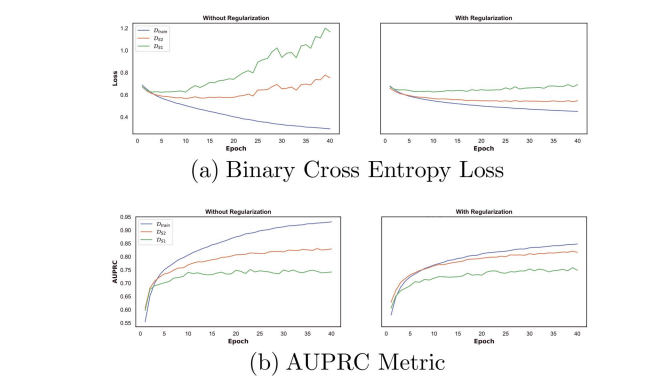

**3. Inductive Setting:** The evaluation also considered the inductive setting, which simulates a cold start problem where the model is presented with new drugs that it was not trained on. In this setting, the performance of the method decreased compared to the transductive setting, but it still exhibited good precision in distinguishing between interacting and non-interacting drug pairs, even for unseen drugs. It is worth noting that other baseline methods also experienced a drop in performance in the inductive setting.

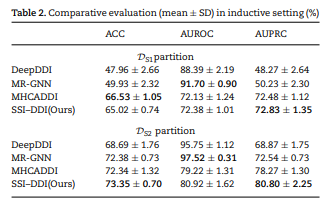

**4. Comparison with Baseline Methods:** The method being evaluated showed competitive performance compared to the baseline methods in both the transductive and inductive settings. Specifically, it performed well in terms of AUROC, which is often affected by imbalanced datasets, while also achieving high AUPRC scores, indicating a high precision in identifying interacting drug pairs.

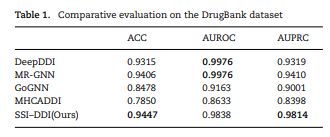